## VGG19 model on Materials in Context Database

In [1]:
import keras
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.callbacks import TensorBoard, ModelCheckpoint
import time
import os
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Dense, Flatten, Activation, Input, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import regularizers

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Read data
Read the pre-split train data, test data and validation data

In [4]:
dataset = 'minc'
split = 5 #1
n_classes = 23
train_dir = 'minc-2500/train'.format(dataset, split)
validate_dir = 'minc-2500/validate'.format(dataset, split)
test_dir = 'minc-2500/test'.format(dataset, split)

In [5]:
# Read data
############ Do some random image transformations to increase the number of training samples
############ Note that we are scaling the image to make all the values between 0 and 1. That's how our pretrained weights have been done too
############ Default batch size is 1 but you can reduce/increase it depending on how powerful your machine is. 
batch_size = 20 #32
img_width = 224
img_height = 224

train_datagen = image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

validate_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 48875 images belonging to 23 classes.
Found 2875 images belonging to 23 classes.
Found 5760 images belonging to 23 classes.


## Construct the model
Import VGG19 model, remove the pre-trained output layer, and add on the output layer to fit the MINC dataset.

In [6]:
# Build Fine-tune network architecture
# Get Image-Net pre-trained model
vgg19_model = keras.applications.VGG19(input_tensor=Input(shape=(224, 224, 3))) #vgg19.
print("<VGG19 model>")
model = keras.Sequential()
# Remove 1000-classes output layer (last layer)
name_last_layer = str(vgg19_model.layers[-1])

for layer in vgg19_model.layers:
    if str(layer) != name_last_layer:
        model.add(layer)


574717952/574710816 [==============================] - 3s 0us/step
<VGG19 model>


In [7]:
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(n_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01),
          bias_regularizer=regularizers.l2(0.01)))

print("<Fine-tuned model>")
model.summary()

<Fine-tuned model>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 5

## Train model
Adam optimizer with learning rate decay is employed. The model is trained for 30 epochs as it converges fast.

In [8]:
initial_learning_rate = 0.0001 
decay_steps = 1000 #40
decay_rate = 0.9
lr = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False, name=None
)

optimizer = keras.optimizers.Adam(learning_rate=lr, epsilon=0.1)
#optimizer = keras.optimizers.SGD(learning_rate=0.005, momentum=0.2)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

# stepsPerEpoch = num_training_img/batch_size
stepsPerEpoch = 800 / batch_size
validationSteps = 200 / batch_size
print("validationSteps: {}".format(validationSteps))
epochs = 30 #5
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=stepsPerEpoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validationSteps,
    #callbacks=[checkpoint]
)
print('Execution time: ', time.time() - start_time)

validationSteps: 10.0
Epoch 1/30
40/40 [==============================] - 369s 9s/step - loss: 4.2343 - accuracy: 0.0487 - val_loss: 4.3244 - val_accuracy: 0.0700
Epoch 2/30
40/40 [==============================] - 326s 8s/step - loss: 3.7107 - accuracy: 0.1300 - val_loss: 3.4241 - val_accuracy: 0.1700
Epoch 3/30
40/40 [==============================] - 316s 8s/step - loss: 3.2664 - accuracy: 0.2325 - val_loss: 3.4491 - val_accuracy: 0.2450
Epoch 4/30
40/40 [==============================] - 316s 8s/step - loss: 2.9288 - accuracy: 0.3162 - val_loss: 2.9166 - val_accuracy: 0.3150
Epoch 5/30
40/40 [==============================] - 309s 8s/step - loss: 2.6587 - accuracy: 0.3587 - val_loss: 2.5665 - val_accuracy: 0.4150
Epoch 6/30
40/40 [==============================] - 307s 8s/step - loss: 2.4759 - accuracy: 0.4300 - val_loss: 2.6724 - val_accuracy: 0.3700
Epoch 7/30
40/40 [==============================] - 280s 7s/step - loss: 2.3401 - accuracy: 0.4550 - val_loss: 2.5647 - val_accuracy

## Evaluate model

In [9]:
best_model = model
evaluator = best_model.evaluate_generator(generator=validation_generator)
loss = evaluator[0]
acc = evaluator[1]
print("[loss, acc] = {}".format(best_model.evaluate_generator(generator=test_generator)))


Instructions for updating:
Please use Model.evaluate, which supports generators.
[loss, acc] = [1.6652542352676392, 0.652430534362793]


## Plot accuracy and loss curves

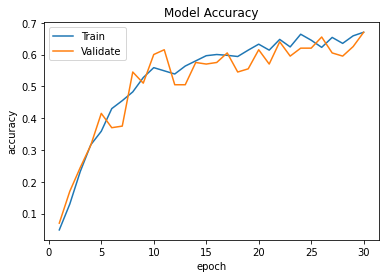

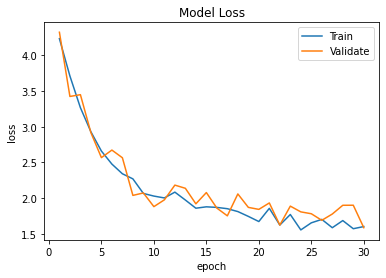

In [10]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
# Save the plot for accuracies
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Validate')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

train_loss = history.history['loss']
test_loss = history.history['val_loss']
# Save the plot for accuracies
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='Validate')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()